### Metadata ###
Este proyecto se ejecuto sobre un ambiento con:
* Python        3.9.13
* tensorflow    2.10 (cpu & gpu) 
* cuda          V11.8.89
* cudnn         8.9.7

### Import Libraries ###

In [1]:
#Load json files into pandas dataframe
import pandas as pd
import os
import numpy as np
import json
from collections import Counter
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [2]:
UNIT_TO_GRID_VALUE = 128

### Loading Data ###

In [3]:
#Search for all json files in the directory
path = r"D:\Proyecto ML - War3\Maps\Converted_to_JSON"

# Init Storage
maps_data = []

# Iterate all the sub folders
for folder_name in os.listdir(path):
    folder_path = os.path.join(path, folder_name)
    
    # Init map structure
    map_data = {"map_name": folder_name, "terrain": None, "trees": None, "units": None}

    # iterate on files
    for file_name in os.listdir(folder_path):
        
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            
            # Assign the data based on the file type
            if "terrain" in file_name.lower():
                map_data["terrain"] = data
            elif "trees" in file_name.lower():
                map_data["trees"] = data
            elif "units" in file_name.lower():
                map_data["units"] = data

    # Add map data to general storage
    maps_data.append(map_data)

# Show first map
maps_data[0]

{'map_name': '_(8)BanditsRetreat_S2_v1.1',
 'terrain': {'errors': [],
  'json': {'tileset': 'A',
   'customTileset': True,
   'tilePalette': ['Bdrt',
    'Bdrh',
    'Avin',
    'Vcbp',
    'Vstp',
    'Ybtl',
    'Agrs',
    'Vrck',
    'Adrg',
    'Lgrd',
    'Adrt'],
   'cliffTilePalette': ['CAgr', 'CAdi'],
   'map': {'width': 160, 'height': 160, 'offset': {'x': -10240, 'y': -10240}},
   'groundHeight': [9335,
    9376,
    9434,
    9470,
    9477,
    9450,
    9391,
    9310,
    9218,
    9141,
    9062,
    8986,
    8916,
    8850,
    8805,
    8793,
    8819,
    8869,
    8947,
    9035,
    9126,
    9200,
    9241,
    9244,
    9192,
    9120,
    9037,
    8980,
    8979,
    9046,
    9170,
    9328,
    9501,
    9674,
    9842,
    10012,
    10175,
    10327,
    10451,
    10531,
    10563,
    10545,
    10481,
    10379,
    10248,
    10104,
    9958,
    9805,
    9640,
    9468,
    9302,
    9188,
    9179,
    9258,
    9364,
    9501,
    9610,
    9695,
  

### Extract relevant info columns ###

In [4]:
#FUNC: transform in to 2D matriz
def transform_to_array(row, column_name):
    width = row["json_map_width"]
    height = row["json_map_height"]
    data = row[column_name]
    # Verificar que los datos sean una lista y que las dimensiones sean correctas
    if isinstance(data, list) and len(data) == (width + 1) * (height + 1):
        return np.array(data).reshape((height + 1, width + 1))
    else:
        print(f"Error en las dimensiones para el índice {row.name}: esperado {width}x{height}, pero hay {len(data)} elementos.")
        return None  # Devuelve None si las dimensiones no coinciden

#Transform in to DF
terrain_df = pd.json_normalize([data["terrain"] for data in maps_data], sep='_')

# Drop unecesary columns
terrain_df.drop(columns=["errors"],inplace = True)
terrain_df.drop(columns=["json_tileset"],inplace = True)
terrain_df.drop(columns=["json_customTileset"],inplace = True)
terrain_df.drop(columns=["json_tilePalette"],inplace = True)
terrain_df.drop(columns=["json_cliffTilePalette"],inplace = True)
terrain_df.drop(columns=["json_groundVariation"],inplace = True)
terrain_df.drop(columns=["json_cliffVariation"],inplace = True)
terrain_df.drop(columns=["json_cliffTexture"],inplace = True)

# Fix Unit to matriz size cell and bolean values
terrain_df["json_map_offset_x"] = terrain_df["json_map_offset_x"] / UNIT_TO_GRID_VALUE
terrain_df["json_map_offset_y"] = terrain_df["json_map_offset_y"] / UNIT_TO_GRID_VALUE
terrain_df["json_groundHeight"] = terrain_df.apply(transform_to_array, axis=1, args=("json_groundHeight",))
terrain_df["json_waterHeight"] = terrain_df.apply(transform_to_array, axis=1, args=("json_waterHeight",))
terrain_df["json_boundaryFlag"] = terrain_df["json_boundaryFlag"].apply(lambda x: [int(v) for v in x])
terrain_df["json_boundaryFlag"] = terrain_df.apply(transform_to_array, axis=1, args=("json_boundaryFlag",))
terrain_df["json_flags"] = terrain_df.apply(transform_to_array, axis=1, args=("json_flags",))
terrain_df["json_groundTexture"] = terrain_df.apply(transform_to_array, axis=1, args=("json_groundTexture",))
terrain_df["json_layerHeight"] = terrain_df.apply(transform_to_array, axis=1, args=("json_layerHeight",))

# Show
terrain_df.head(3)

,json_map_width,json_map_height,json_map_offset_x,json_map_offset_y,json_groundHeight,json_waterHeight,json_boundaryFlag,json_flags,json_groundTexture,json_layerHeight
0,160,160,-80.0,-80.0,"[[9335, 9376, 9434, 9470, 9477, 9450, 9391, 93...","[[8704, 8704, 8704, 8704, 8704, 8704, 8704, 87...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, ...","[[2, 2, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 2, 6, 2,...","[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
1,160,160,-80.0,-80.0,"[[9629, 9629, 9629, 9629, 9629, 9629, 9629, 96...","[[10705, 10705, 10705, 10705, 10705, 10705, 10...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, ...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
2,160,160,-80.0,-80.0,"[[9629, 9629, 9629, 9629, 9629, 9629, 9629, 96...","[[10705, 10705, 10705, 10705, 10705, 10705, 10...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, ...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [5]:
# Transform in to DF
trees_df = pd.json_normalize([data["trees"] for data in maps_data], sep='_')

# FUNC: Tranform column in splited columns.
def transform_elements(_input, column_name):
    transformed = {}
    for key in _input[0].keys(): # for each key
        new_column_name = f"{column_name}.{key}"
        transformed[new_column_name] = [element[key] for element in _input]
    return pd.Series(transformed)

# FUNC: Modifie cordinates of elemnts.
def process_positions(positions):
    coords = positions
    processed_coords = [
        [round(coord / UNIT_TO_GRID_VALUE) for coord in coord_set] for coord_set in coords
    ]
    return processed_coords

# FUNC: Get unique values from a column of arrays. 
def get_unique_values(column):
    unique_values = set(value for array in column for value in array)
    return unique_values

# FUNC: Transforms a column of boolean arrays into numeric arrays
def boolean_to_numeric(df, column_name):
    return df[column_name].apply(lambda arr: [1 if val else 0 for val in arr])

# FUNC: combine binary columns
def combine_arrays(arr1, arr2):
    mapping = {
        (0, 0): 1,
        (1, 0): 2,
        (0, 1): 3,
        (1, 1): 4
    }
    return [mapping[(x, y)] for x, y in zip(arr1, arr2)]

# FUNC: Count elemnt in column whit arrays
def count_elements(column):
    flat_list = [item for sublist in column for item in sublist]
    return dict(Counter(flat_list))

# FUNC: Generate Matices of data
def gnerate_matices(positions, tag, width, height, offset_x, offset_y):
    reduced_width = width // 2
    reduced_height = height // 2
    tex_solid_reduced = np.zeros((reduced_height +1, reduced_width +1), dtype=int)
    tex_trans_reduced = np.zeros((reduced_height +1, reduced_width +1), dtype=int)
    for pos, t in zip(positions, tag):
        x, y, z = pos  # Extraer las coordenadas x, y, z
        adjusted_x = int((x - offset_x)/2)
        adjusted_y = int((y - offset_y)/2)
        if 0 <= adjusted_x <= reduced_width and 0 <= adjusted_y <= reduced_height:
            if t == 1:  # Si el tag es 1, añadir a tex_solid
                tex_solid_reduced[adjusted_y, adjusted_x] = 1
            elif t == 4:  # Si el tag es 4, añadir a tex_trans
                tex_trans_reduced[adjusted_y, adjusted_x] = 1
        else:
            print(f"Debug: adj_x = {adjusted_x}, adj_y = {adjusted_y}, Fuera de los bordes")
    
    tex_solid = zoom(tex_solid_reduced, zoom=2, order=0)
    tex_trans = zoom(tex_trans_reduced, zoom=2, order=0)        
    return tex_solid, tex_trans

# Split "json" column
c = trees_df["json"]
trees_df = c.apply(transform_elements, args=("ambient",))
splited_flags =  trees_df["ambient.flags"].apply(transform_elements,args=("ambient.flags",))
trees_df = pd.concat([trees_df.drop(columns=["ambient.flags"]),splited_flags], axis=1)

# transform data to make usable
trees_df["ambient.position"] = trees_df["ambient.position"].apply(process_positions)
trees_df["ambient.flags.visible"] = boolean_to_numeric(trees_df, "ambient.flags.visible")
trees_df["ambient.flags.solid"] = boolean_to_numeric(trees_df, "ambient.flags.solid")
trees_df["combined.Visible.Solid"] = trees_df.apply(lambda row: combine_arrays(row["ambient.flags.visible"], row["ambient.flags.solid"]), axis=1)
trees_df[["solid_texture", "trans_texture"]] = trees_df.apply(
    lambda row: pd.Series(
        gnerate_matices(
            row["ambient.position"],
            row["combined.Visible.Solid"],
            terrain_df.loc[row.name,"json_map_width"],
            terrain_df.loc[row.name,"json_map_height"],
            terrain_df.loc[row.name,"json_map_offset_x"],
            terrain_df.loc[row.name,"json_map_offset_y"],
        )
    ),
    axis=1,)

# Drop unecesary columns
trees_df.drop(columns=["ambient.type"],inplace = True)
trees_df.drop(columns=["ambient.angle"],inplace = True)
trees_df.drop(columns=["ambient.skinId"],inplace = True)
trees_df.drop(columns=["ambient.id"],inplace = True)
trees_df.drop(columns=["ambient.scale"],inplace = True)
trees_df.drop(columns=["ambient.life"],inplace = True)
trees_df.drop(columns=["ambient.variation"],inplace = True)
trees_df.drop(columns=["ambient.position"],inplace = True)
trees_df.drop(columns=["ambient.flags.visible"],inplace = True)
trees_df.drop(columns=["ambient.flags.solid"],inplace = True)
trees_df.drop(columns=["combined.Visible.Solid"],inplace = True)

# Show
trees_df.head(3)


,solid_texture,trans_texture
0,"[[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [6]:
# FUNC: Generate Matices of data
def gnerate_matices(positions, tag, width, height, offset_x, offset_y):
    reduced_width = width // 2
    reduced_height = height // 2

    gold_reduced = np.zeros((reduced_height +1, reduced_width  +1), dtype=int)
    other_reduced = np.zeros((reduced_height +1, reduced_width  +1), dtype=int)
    for pos, t in zip(positions, tag):
        x, y, z = pos  # Extraer las coordenadas x, y, z
        adjusted_x = int((x - offset_x) / 2) 
        adjusted_y = int((y - offset_y) / 2) 
        if 0 <= adjusted_x <= reduced_width and 0 <= adjusted_y <= reduced_height:
            if t != 0:  # Si el tag es 1, añadir a tex_solid
                gold_reduced[adjusted_y, adjusted_x] = 1
            elif t == 0:  # Si el tag es 4, añadir a tex_trans
                gold_reduced[adjusted_y, adjusted_x] = 1 #other_reduced[adjusted_y, adjusted_x] = 1
        else:
            print(f"Debug: adj_x = {adjusted_x}, adj_y = {adjusted_y}, Fuera de los bordes")

    gold = zoom(gold_reduced, zoom=2, order=0)
    other = zoom(other_reduced, zoom=2, order=0)        
    return gold, other

# Transform in to DF
units_df = pd.json_normalize([data["units"] for data in maps_data], sep='_')

# Split "json" column
c = units_df["json"]
units_df = c.apply(transform_elements, args=("builds",))

# Transform data
units_df["builds.position"] = units_df["builds.position"].apply(process_positions)
units_df[["builds.gold_mine", "builds.others"]] = units_df.apply(
    lambda row: pd.Series(
        gnerate_matices(
            row["builds.position"],
            row["builds.gold"],
            terrain_df.loc[row.name,"json_map_width"],
            terrain_df.loc[row.name,"json_map_height"],
            terrain_df.loc[row.name,"json_map_offset_x"],
            terrain_df.loc[row.name,"json_map_offset_y"],
        )
    ),
    axis=1,)

# Drop unecesary columns
units_df.drop(columns=["builds.type"],inplace = True)
units_df.drop(columns=["builds.rotation"],inplace = True)
units_df.drop(columns=["builds.scale"],inplace = True)
units_df.drop(columns=["builds.hero"],inplace = True)
units_df.drop(columns=["builds.inventory"],inplace = True)
units_df.drop(columns=["builds.abilities"],inplace = True)
units_df.drop(columns=["builds.hitpoints"],inplace = True)
units_df.drop(columns=["builds.mana"],inplace = True)
units_df.drop(columns=["builds.targetAcquisition"],inplace = True)
units_df.drop(columns=["builds.color"],inplace = True)
units_df.drop(columns=["builds.id"],inplace = True)
units_df.drop(columns=["builds.variation"],inplace = True)
units_df.drop(columns=["builds.position"],inplace = True)
units_df.drop(columns=["builds.player"],inplace = True)
units_df.drop(columns=["builds.gold"],inplace = True)

units_df.drop(columns=["builds.others"],inplace = True)

# Show
units_df.head(3)



,builds.gold_mine
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


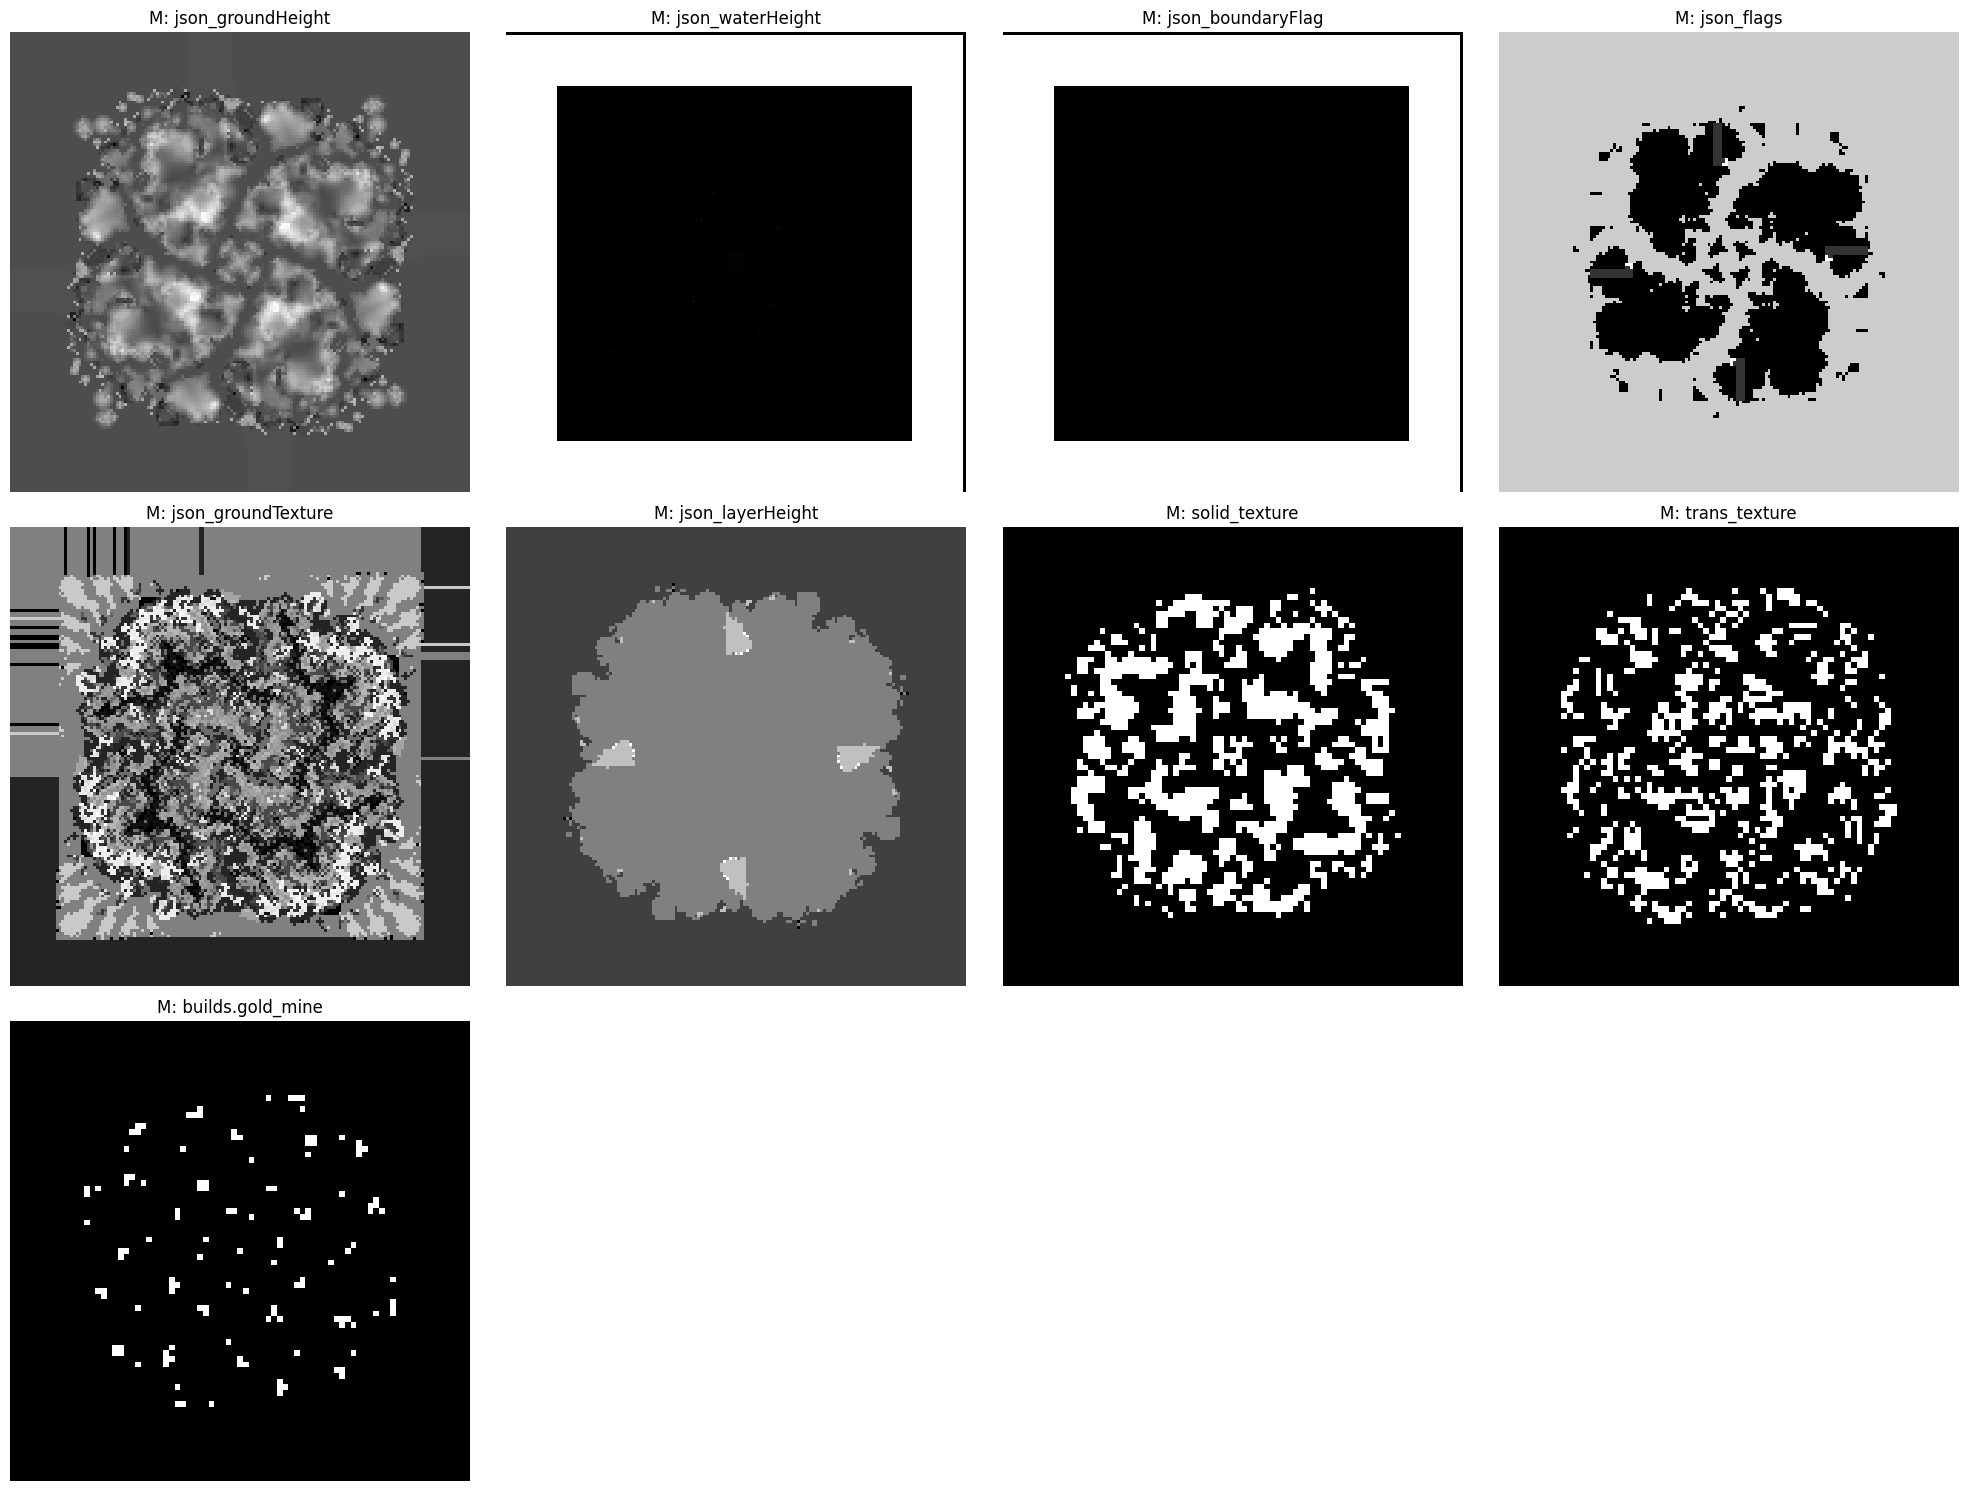

El tamaño más pequeño en 'builds.gold_mine' es: 98x98


In [7]:
# Convine all
df = combined_df = pd.concat([terrain_df, trees_df, units_df], axis=1)
df["map_name"] = [map_data["map_name"] for map_data in maps_data]

# FUNC: plot matriz
def plot_all_matrices(row):
    matrices_to_plot = []
    column_names = []
    #title = row["map_name"]
    for column_name, value in row.items():

        if isinstance(value, list):
            value = np.array(value)
        
        # Verifica si es una matriz 2D
        if isinstance(value, np.ndarray) and len(value.shape) == 2:
            matrices_to_plot.append(value)
            column_names.append(column_name)
            
    num_matrices = len(matrices_to_plot)
    cols = min(4, num_matrices)  
    rows = (num_matrices + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 5 * rows))
    #plt.suptitle(f"Map: {title}", fontsize=16)
    for idx, (matrix, column_name) in enumerate(zip(matrices_to_plot, column_names)):
        plt.subplot(rows, cols, idx + 1)  # Crear subgráfica
        plt.imshow(matrix, cmap="gray", interpolation="nearest")
        plt.title(f"M: {column_name}")
        plt.axis("off")  # Quitar los ejes
    plt.tight_layout()  # Mejorar espaciado entre subgráficas
    plt.show()

# Show
#df.head(3)
first_row = df.iloc[50]
plot_all_matrices(first_row)

# Extra info
#columns = [(col, df[col].dtype) for col in df.columns]
#print(columns)
min_height = min(matrix.shape[0] for matrix in df['builds.gold_mine'] if isinstance(matrix, np.ndarray))  # Altura mínima
min_width = min(matrix.shape[1] for matrix in df['builds.gold_mine'] if isinstance(matrix, np.ndarray))   # Anchura mínima
print(f"El tamaño más pequeño en 'builds.gold_mine' es: {min_height}x{min_width}")

### SUB Plot

In [8]:
# copy
df_subploted = df.copy()

# Remove Extra columns
df_subploted.drop(columns=["json_map_width"],inplace = True)
df_subploted.drop(columns=["json_map_height"],inplace = True)
df_subploted.drop(columns=["json_map_offset_x"],inplace = True)
df_subploted.drop(columns=["json_map_offset_y"],inplace = True)
df_subploted.drop(columns=["map_name"],inplace = True)

# FUNC: Cut sub-Plot
def find_extreme_positions(matrix, margin=4):
    # Encuentra todas las posiciones de 1 en la matriz
    positions = np.argwhere(matrix != 1)

    # Filtrar las posiciones que están dentro del margen
    positions = positions[
        (positions[:, 0] >= margin) & (positions[:, 1] >= margin) & 
        (positions[:, 0] < matrix.shape[0] - margin) & 
        (positions[:, 1] < matrix.shape[1] - margin)
    ]
    y_min, x_min = positions.min(axis=0)
    y_max, x_max = positions.max(axis=0)
    return (x_min, y_min), (x_max, y_max)

# FUNC: crop matrix
def crop_matrix(matrix, x_min, y_min, x_max, y_max):
    cropped_matrix = matrix[y_min:y_max+1, x_min:x_max+1]
    return cropped_matrix

# FUNC: grenerate sub-plot removing borders.
def process_dataframe(df, mask_column):
    def process_row(row): # sub function
        mask = row[mask_column]
        height, width = mask.shape
        (x_min, y_min), (x_max, y_max) = find_extreme_positions(mask)
        #print(f"Puntos de recorte: (x_min, y_min) = ({x_min}, {y_min}), (x_max, y_max) = ({x_max}, {x_max})")
        for col in row.index:
            row[col] = crop_matrix(row[col], x_min, y_min, x_max, y_max)
        return row
    df = df.apply(process_row, axis=1)
    return df


df_subploted = process_dataframe(df_subploted, 'json_boundaryFlag')
df_subploted.drop(columns=["json_boundaryFlag"],inplace = True)

# Show
df_subploted.head(3)
#first_row = df_subploted.iloc[50]
#plot_all_matrices(first_row)

,json_groundHeight,json_waterHeight,json_flags,json_groundTexture,json_layerHeight,solid_texture,trans_texture,builds.gold_mine
0,"[[10463, 10351, 10218, 10081, 9965, 9888, 9855...","[[8704, 8704, 8704, 8704, 8704, 8704, 8704, 87...","[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, ...","[[7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...","[[4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4,...","[[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[9629, 9629, 9629, 9629, 9681, 9681, 9681, 96...","[[10705, 10705, 10705, 10705, 10705, 10705, 10...","[[64, 64, 64, 64, 64, 64, 64, 64, 0, 0, 0, 0, ...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...","[[2, 3, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 5, 3,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[9629, 9629, 9629, 9629, 9629, 9681, 9681, 96...","[[10705, 10705, 10705, 10705, 10705, 10705, 10...","[[64, 64, 64, 64, 64, 64, 64, 64, 0, 0, 0, 0, ...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5,...","[[2, 3, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 5, 3,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Normalize Values ###

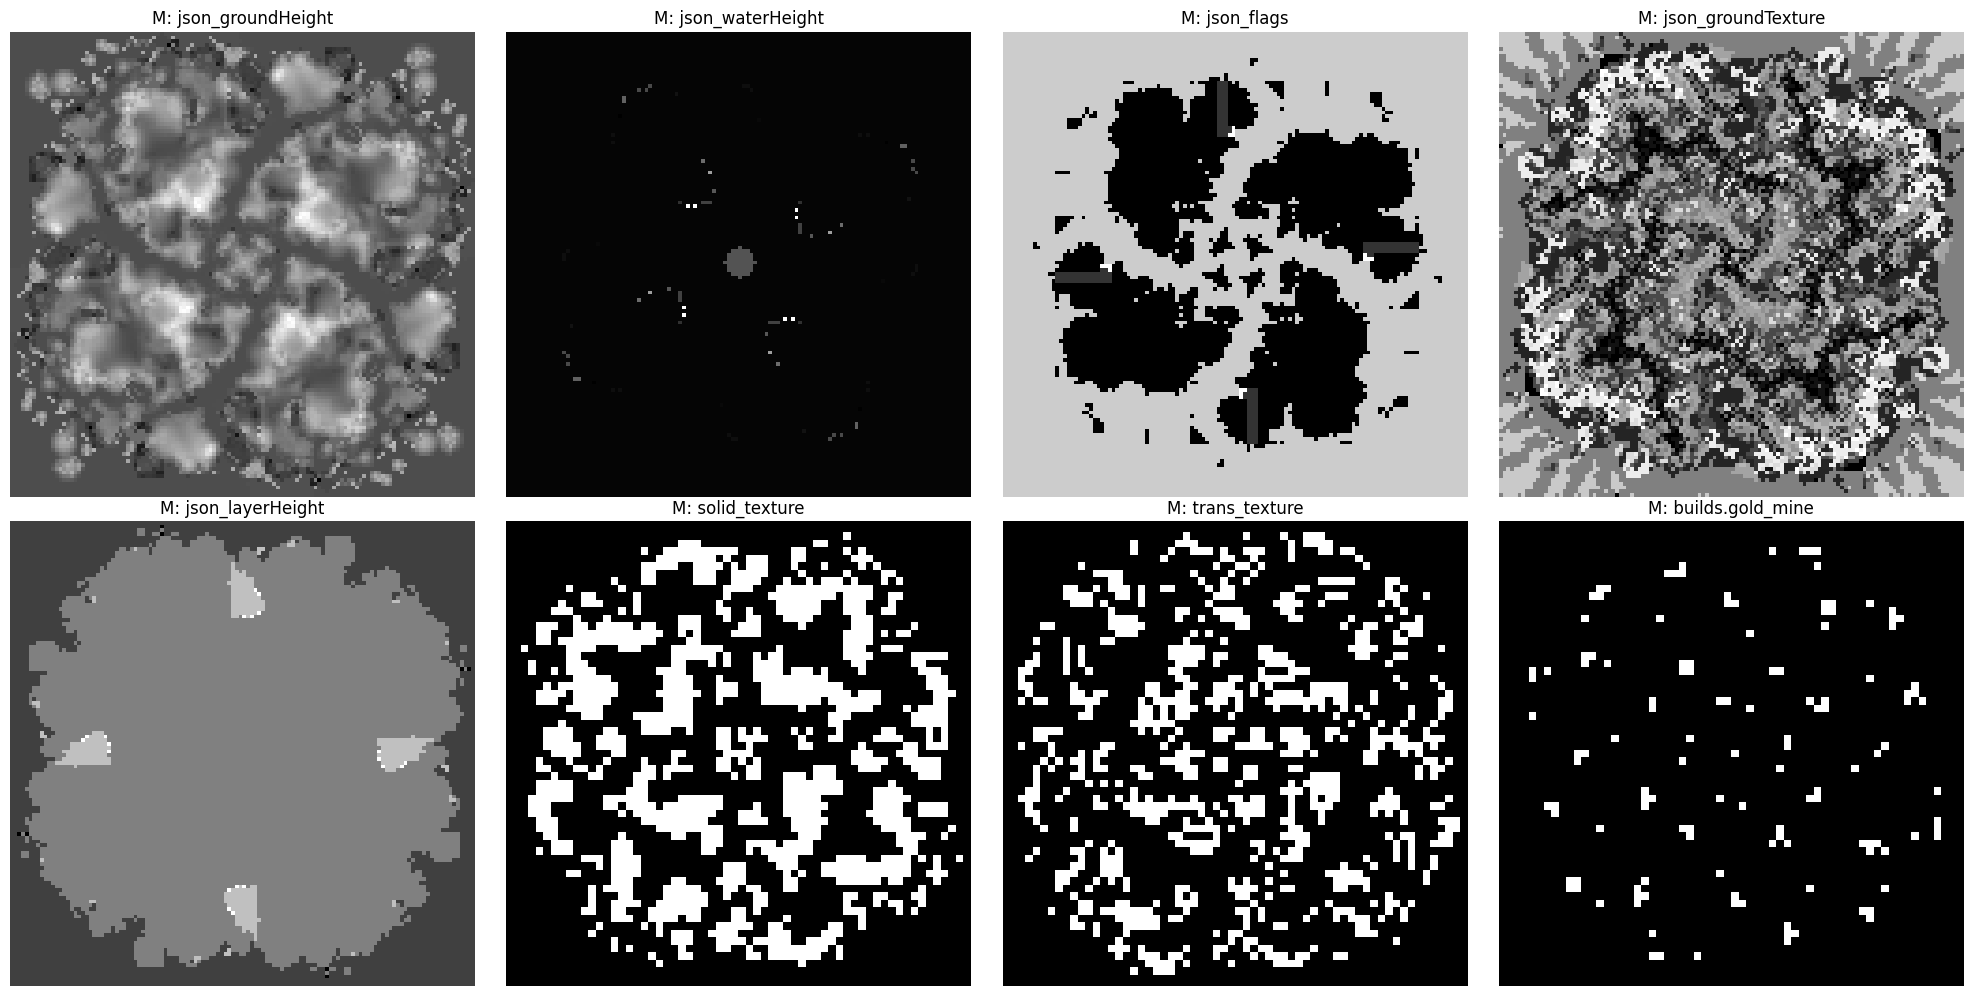

In [9]:
# Prapare data
normalize_df = df_subploted.copy()

# FUNC: Normalice each matriz
def normalize_matrix(matrix, matrix_min=None, matrix_max=None):
    # get min an max for each matrx (parchado para ground y water)
    if matrix_min is None:
        matrix_min = matrix.min()
    if matrix_max is None:
        matrix_max = matrix.max()
    
    if matrix_max != matrix_min:
        return (matrix - matrix_min) / (matrix_max - matrix_min)
    else:
        return (matrix)  # Do nothing

# Calc min/max for columns 'water'/'ground'
combined_min = min(
    normalize_df["json_waterHeight"].apply(lambda x: x.min()).min(),
    normalize_df["json_groundHeight"].apply(lambda x: x.min()).min()
)
combined_max = max(
    normalize_df["json_waterHeight"].apply(lambda x: x.max()).max(),
    normalize_df["json_groundHeight"].apply(lambda x: x.max()).max()
)

# Apply normalization
for column in normalize_df.columns:
    if column in ["json_waterHeight", "json_groundHeight"]:
        # Normalizar usando valores combinados
        normalize_df[column] = normalize_df[column].apply(
            lambda x: normalize_matrix(x, matrix_min=combined_min, matrix_max=combined_max)
        )
    else:
        normalize_df[column] = normalize_df[column].apply(lambda x: normalize_matrix(x))

# Show
normalize_df.head(3)
first_row = normalize_df.iloc[50]
plot_all_matrices(first_row)

### Data aumentation ###

In [10]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# FUNC: Split bigest map in to small sub-map
def extract_patches(matrix, patch_height, patch_width):
    h, w = matrix.shape
    #print(f"Dimensiones h w: {h}x{w}")
    patches = []

    for i in range(0, h - patch_height + 1, patch_height):
        for j in range(0, w - patch_width + 1, patch_width):
            patch = matrix[i:i+patch_height, j:j+patch_width]
            patches.append(patch)  
    return patches

# FUNC: Apply transformation to make data aumentation
def generate_rotations_and_reflections(matrix):
    transformed_matrices = [] 

    # Rotation
    transformed_matrices.append(matrix)  # Rotation 0°
    transformed_matrices.append(np.rot90(matrix))  # Rotation 90°
    transformed_matrices.append(np.rot90(matrix, 2))  # Rotation 180°
    transformed_matrices.append(np.rot90(matrix, 3))  # Rotation 270°

    # Mirror
    transformed_matrices.append(np.fliplr(matrix))  # Mirror horizontal
    transformed_matrices.append(np.flipud(matrix))  # Mirror vertical
    transformed_matrices.append(np.fliplr(np.rot90(matrix)))  # Rotation 90° + Mirror horizontal
    transformed_matrices.append(np.fliplr(np.rot90(matrix, 3)))  # Rotation 270° + Mirror horizontal

    return transformed_matrices

# Prapare data
data_df = normalize_df.copy()

# Get mins
CROP_HEIGHT = 64
CROP_WIDTH = 64

# extract big maps in to smaller part
augmented_data = []
for row in data_df.itertuples(index=False):
    row_patches = [] 
    for matrix in row:
        patches = extract_patches(matrix, CROP_HEIGHT, CROP_WIDTH)
        row_patches.append(patches)

    num_patches = len(row_patches[0])   
    for i in range(num_patches):
        new_row = []
        for patches in row_patches:
            new_row.append(patches[i])
        augmented_data.append(tuple(new_row))  

# Extract mirror and rotate maps
augmented_df = pd.DataFrame(augmented_data)
augmented_data_2 = []
for row in augmented_df.itertuples(index=False):
    row_matrices = list(row)
    transformed_rows = []
    for matrix in row_matrices:
        transformed_matrices = generate_rotations_and_reflections(matrix)
        transformed_rows.append(transformed_matrices)

    num_transformations = len(transformed_rows[0])
    for i in range(num_transformations):
            new_row = []
            for transformed_matrix in transformed_rows:
                new_row.append(transformed_matrix[i])
            augmented_data_2.append(tuple(new_row))

augmented_df_2 = pd.DataFrame(augmented_data_2)

# Rename columns
original_column_names = data_df.columns.tolist()
augmented_df_2.columns = original_column_names

# Show
augmented_df_2.head(3)

# Extra info
#num_rows = augmented_df_2.shape[0]  # Número de filas
#num_cols = augmented_df_2.shape[1]  # Número de columnas
#print(f"Forma del DataFrame de parches: {num_rows} filas, {num_cols} columnas")
#first_row = augmented_df_2.iloc[50]
#plot_all_matrices(first_row)

#print(f"cantidad de mapas: {len(augmented_df_2)}")


,json_groundHeight,json_waterHeight,json_flags,json_groundTexture,json_layerHeight,solid_texture,trans_texture,builds.gold_mine
0,"[[0.5504134860050891, 0.5326017811704835, 0.51...","[[0.27067430025445294, 0.27067430025445294, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7777777777777778, 0.7777777777777778, 0.22...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0,...","[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[0.4098282442748092, 0.40044529262086515, 0.3...","[[0.27067430025445294, 0.27067430025445294, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.2222222222222222, 0.2222222222222222, 1.0,...","[[0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.20244910941475827, 0.20165394402035625, 0....","[[0.27067430025445294, 0.27067430025445294, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3333333333333333, 0.3333333333333333, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### GPU Activation ###

In [11]:
# Test tensorflow
#import tensorflow as tf
#print("TensorFlow version:", tf.__version__)
#print("Is GPU available:", tf.config.list_physical_devices('GPU'))

In [12]:
import tensorflow as tf
# CHATGPTEADO REVISAR POR QUE FUNCIONA
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configura TensorFlow para que use la memoria de manera dinámica
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### AutoEncoder model ###

In [21]:
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# MODEL (clasic autoencoder)
class Autoencoder(Model):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.2),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        ])
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Dropout(0.2),
            layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same'),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def generate(self, latent_space_input):
        return self.decoder(latent_space_input) 
    
    def get_latent_space_shape(self, input_shape):
        dummy_input = tf.random.normal([1] + list(input_shape))
        latent_space_output = self.encoder(dummy_input) 
        return latent_space_output.shape[1:] 
        
# copy
conv_df = augmented_df_2.copy()

# Transform df to tensor (dim + 1)
expanded_data = []
for _, row in conv_df.iterrows():
    channels = []
    for col in conv_df.columns:
        channels.append(row[col])

    cube_info = np.stack(channels, axis=0)
    expanded_data.append(cube_info)

expanded_data = np.array(expanded_data)
print("Forma final del cubo de información:", expanded_data.shape)

tensor = expanded_data.copy()
tensor = np.transpose(expanded_data, (0, 2, 3, 1))

# Split in to train and test
X_train, X_test = train_test_split(tensor, test_size=0.2, random_state=42)
input_shape = X_train.shape[1:]
print("Forma input:",input_shape)

# Init Autoencoder
input_layer = layers.Input(shape=input_shape)
autoencoder = Autoencoder(input_shape)

# compilation
autoencoder.compile(optimizer='RMSprop', loss='mae') #binary_crossentropy #mae #mse
#Adam #SGD #RMSprop

# Show
autoencoder.build(input_shape=(None, *input_shape))
autoencoder.summary()
latent_space_shape = autoencoder.get_latent_space_shape(input_shape)
print(f"El tamaño del espacio latente es: {latent_space_shape}")


Forma final del cubo de información: (1664, 8, 64, 64)
Forma input: (64, 64, 8)
Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 8, 8, 256)         389856    
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 8)         389608    
                                                                 
Total params: 779,464
Trainable params: 779,464
Non-trainable params: 0
_________________________________________________________________
El tamaño del espacio latente es: (8, 8, 256)


### Autoencoder Training ###

In [22]:
# GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

# Early Stop
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=10,            
    restore_best_weights=True
)

# Trainig
history = autoencoder.fit(X_train, X_train, 
                validation_data=(X_test, X_test),
                epochs=1000, 
                batch_size=32, 
                callbacks=[early_stopping])

Epoch 1/1000
42/42 [==============================] - 2s 25ms/step - loss: 0.4742 - val_loss: 0.3774
Epoch 2/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.4339 - val_loss: 0.3546
Epoch 3/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.4068 - val_loss: 0.3546
Epoch 4/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.3963 - val_loss: 0.3388
Epoch 5/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.3905 - val_loss: 0.3417
Epoch 6/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.3864 - val_loss: 0.3314
Epoch 7/1000
42/42 [==============================] - 1s 17ms/step - loss: 0.3822 - val_loss: 0.3303
Epoch 8/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.3799 - val_loss: 0.3316
Epoch 9/1000
42/42 [==============================] - 1s 16ms/step - loss: 0.3765 - val_loss: 0.3224
Epoch 10/1000
42/42 [==============================] - 1s 17ms/step - loss: 0.3738 - val_lo

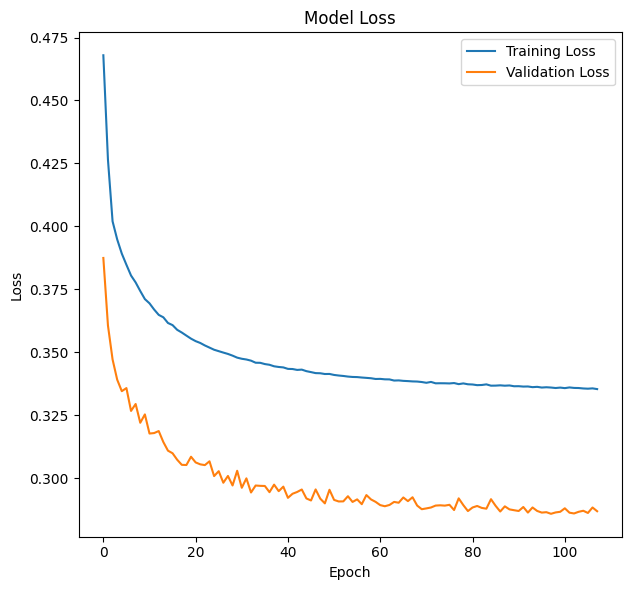

In [15]:
# Visualización del entrenamiento
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE (si estás utilizando métricas adicionales como MAE)
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar resultados
plot_training_history(history)

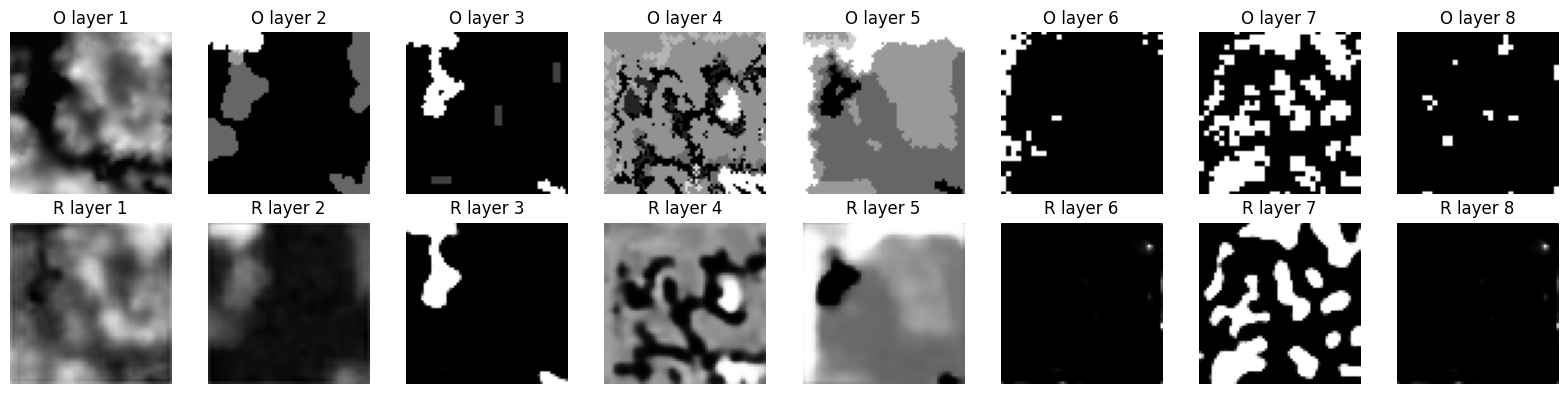

In [17]:
import matplotlib.pyplot as plt

# Select
n = 0
sample = X_test[n:n+1] 
reconstructed_sample = autoencoder(sample)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axes[0, i].imshow(sample[0, :, :, i], cmap='gray')  
    axes[0, i].set_title(f'O layer {i+1}')
    axes[0, i].axis('off') 

for i in range(8):
    axes[1, i].imshow(reconstructed_sample[0, :, :, i], cmap='gray') 
    axes[1, i].set_title(f'R layer {i+1}')
    axes[1, i].axis('off')  

plt.tight_layout()
plt.show()


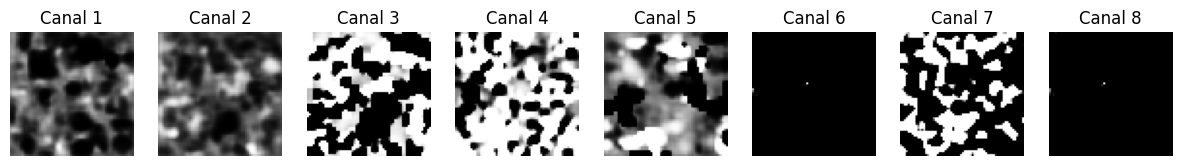

In [18]:
# Latent space
latent_space_shape = autoencoder.get_latent_space_shape(input_shape)

# FUNC: Create Image from noise
def generate_image(autoencoder, latent_dim):
    random_noise = np.random.normal(0, 1, (1,) + latent_dim) 
    generated_image = autoencoder.generate(random_noise)
    
    # Show
    num_channels = generated_image.shape[-1]
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    for i in range(num_channels):
        axes[i].imshow(generated_image[0, :, :, i], cmap='gray') 
        axes[i].set_title(f'Canal {i + 1}')
        axes[i].axis('off')

    plt.show()

# Call func
generate_image(autoencoder, latent_space_shape)

### VAE Model ###

In [34]:
import os
import keras.backend
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# copy
conv_df = augmented_df_2.copy()

# Transform df to tensor (dim + 1)
expanded_data = []
for _, row in conv_df.iterrows():
    channels = []
    for col in conv_df.columns:
        channels.append(row[col])

    cube_info = np.stack(channels, axis=0)
    expanded_data.append(cube_info)

expanded_data = np.array(expanded_data)
print("Forma final del cubo de información:", expanded_data.shape)

tensor = expanded_data.copy()
tensor = np.transpose(expanded_data, (0, 2, 3, 1))

# Samplig
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed =  1337 # <- dif

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), seed=self.seed) #np.random.normal(loc=0.0, scale=1.0, size=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2
# Encoder
encoder_inputs = keras.Input(shape=(input_shape))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
#x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
# latent space
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x) # <- dif
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary() # el resultado es "encoder"

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
#x = layers.Dropout(0.2)(x)
decoder_outputs = layers.Conv2DTranspose(input_shape[-1], 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# MODEL (VAE)
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), ## OJO BinaryCross
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Split in to train and test
X_train, X_test = train_test_split(tensor, test_size=0.2, random_state=42)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
input_shape = X_train.shape[1:]
print("Forma input:",input_shape)

# Init VAN
vae = VAE(encoder, decoder)

# compilation
vae.compile(optimizer=keras.optimizers.Adam()) #binary_crossentropy #mae #mse

#Adam #SGD #RMSprop


Forma final del cubo de información: (1664, 8, 64, 64)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 64, 64, 8)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 32, 32)   2336        ['input_20[0][0]']               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 16, 16, 64)   18496       ['conv2d_37[0][0]']              
                                                                                                  
 conv2d_39 (Conv2D)             (None, 8, 8, 128)    73856       ['conv2d_38[0][0]']              
                                     

### VAE Training ###

In [36]:
# GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    
# Early Stop
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=10,            
    restore_best_weights=True
)

# FIT
vae.fit(X_train,
        epochs=30,
        batch_size=32)
        #callbacks=[early_stopping])

#vae.fit(
#    X_train,
#    epochs=30,
#    batch_size=128)

Epoch 1/30
42/42 [==============================] - 1s 20ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 2/30
42/42 [==============================] - 1s 16ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 3/30
42/42 [==============================] - 1s 17ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 4/30
42/42 [==============================] - 1s 16ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 5/30
42/42 [==============================] - 1s 17ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 6/30
42/42 [==============================] - 1s 16ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 7/30
42/42 [==============================] - 1s 16ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 8/30
42/42 [==============================] - 1s 16ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 9/30
42/42 [==============================